### Quick visualization of CLM, EvapTrans, and Pressure outputs  
In order to quickly do a visual check of PFCLM run variables, this notebook 
1. Reads in pfb output files
2. Plots single CLM variable for one timestep (you can change variable, but would have to load in new pfb to check other timsteps here)  
3. Creates a subplot of all CLM variables for one timestep, saves fig in this directory  
4. Plots EvapTrans top soil layer for one timestep (would have to load in new pfb to check other timsteps here)  
5. Plots top Pressure at one timestep

In [1]:
## load PFCLM output and make plots / do analysis

from parflow.tools.fs import get_absolute_path
import parflow as pf
from parflow import Run

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import glob
import xarray as xr
import time
import os

from osgeo import gdal

In [2]:
relative_path_to_runfolder = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs'
run_name = 'spinup.wy2003'

#relative_path_to_runfolder = '/glade/scratch/tijerina/CONUS2/scaling_runs/spinup_scaling/outputs_r9_0-25_4'
#run_name = 'spinup.scaling.9.70_54'

run = Run.from_definition(f'{relative_path_to_runfolder}/{run_name}.pfidb')
data = run.data_accessor

# formatting the mask so that values outside the domain are NA and inside the domain are 1
# check with mask that has 0 and 1
mask = data.mask
active_mask=mask.copy()
active_mask[active_mask > 0] = 1

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
Solver.OverlandKinematic: Field SeepageOne is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
Solver.OverlandKinematic: Field SeepageTwo is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


In [3]:
active_mask[9,2000:2005,2000:2005]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

#### 1. Read in CLM, EvapTrans, and Pressure files (pfb)

In [4]:
# timestep of file you want to read
timestep = '00216' #hourly timestep, 5 digits

In [5]:
clm_file = pf.read_pfb(f'{relative_path_to_runfolder}/{run_name}.out.clm_output.{timestep}.C.pfb')
ET_file = pf.read_pfb(f'{relative_path_to_runfolder}/{run_name}.out.evaptrans.{timestep}.pfb') * active_mask
press_file = pf.read_pfb(f'{relative_path_to_runfolder}/{run_name}.out.press.{timestep}.pfb') * active_mask

#### 2. Plot single CLM variable for one timestep

Text(0.5, 1.0, 'CLM variable 0, timestep 00216')

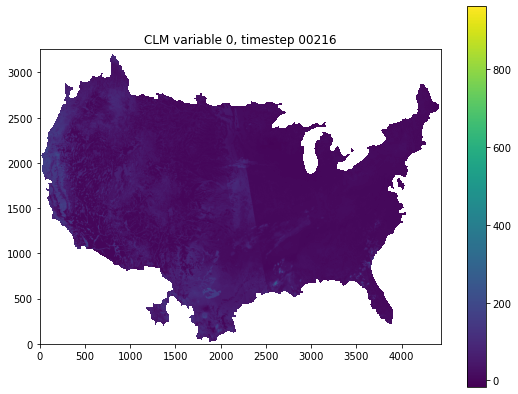

In [6]:
 # the value in the first index determines the CLM variable to be plotted (e.g. [2, :, :] = Sensible Heat)
# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0  total latent heat flux (Wm-2) 1
# 1  total upward LW radiation (Wm-2)  1 nan
# 2  total sensible heat flux (Wm-2) 1 nan
# 3  ground heat flux (Wm-2) 1 nan
# 4  net veg. evaporation and transpiration and soil evaporation (mms-1) 1
# 5  ground evaporation (mms-1) 1
# 6  soil evaporation (mms-1) 1
# 7  vegetation evaporation (canopy) and transpiration (mms-1) 0
# 8  transpiration (mms-1) 0
# 9  infiltration flux (mms-1) 0?
# 10 SWE (mm) 0
# 11 ground temperature (K) 0 nan
# 12 irrigation flux
# 13 - 17 Soil temperature by layer (K) nan

# SET CLM VAR YOU WANT TO CHECK (from list above)
clm_var = 0

clm_file[clm_file < -9000] = 'Nan'
clm_var_timestep1 = clm_file[clm_var, :, :]

plt.figure(figsize = (9,7))
plt.imshow(clm_var_timestep1, origin="lower")
plt.colorbar()
plt.title(f'CLM variable {clm_var}, timestep {timestep}')

#### 3. Create a subplot of all CLM variables

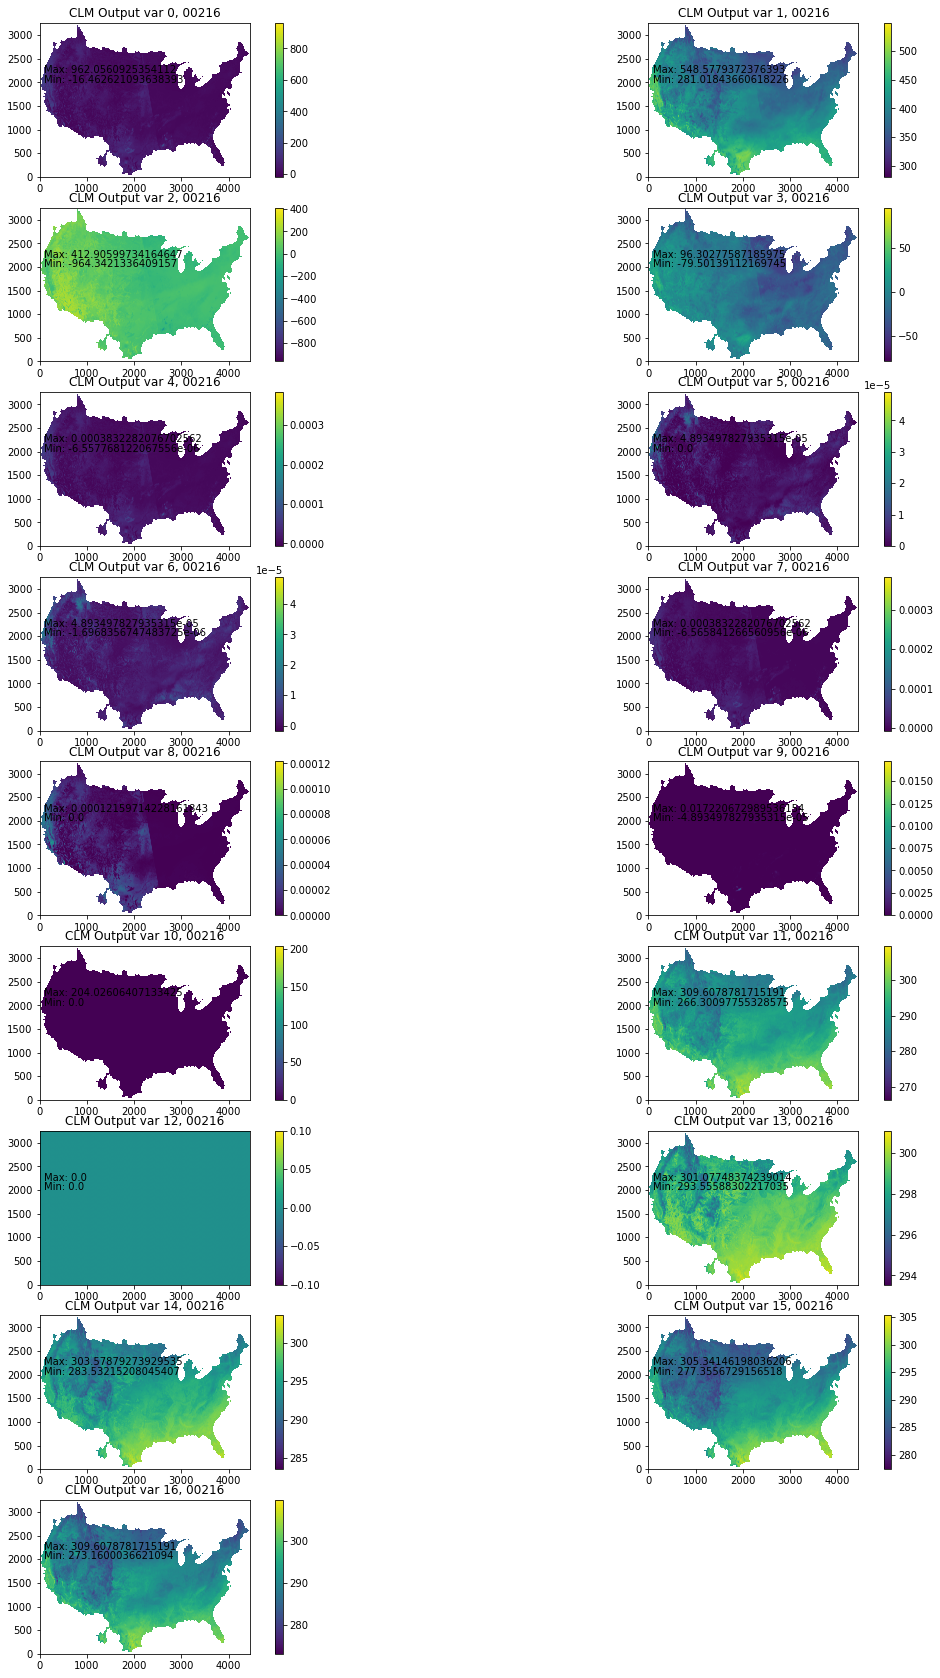

In [7]:
# Plot all CLM variables for the first hour
plt.subplots(5,2, figsize = (20,30))
for i in range (17):
    img_np = clm_file[i]
    plt.subplot(9,2,1+i)
    plt.imshow(img_np, origin="lower")
    plt.colorbar()
    plt.title(f'CLM Output var {i}, {timestep}')
    plt.annotate(f'Max: {np.nanmax(clm_file[i])}', xy = (100,2200))
    plt.annotate(f'Min: {np.nanmin(clm_file[i])}', xy = (100,2000))

#plt.savefig(f'CLM-update_CLM-variables_{timestep}.png',dpi=300)
plt.show()

# plt.subplots(9,2, figsize = (20,30))
# for i in range (17):
#     img_np = clm_00001[i]
#     plt.subplot(9,2,1+i)
#     plt.imshow(img_np, origin="lower")
#     plt.colorbar()
#     plt.title(f'clm_var_timestep1 {i}')
#     plt.annotate(f'Max: {clm_00001[i].max()}', xy = (100,2200))
#     plt.annotate(f'Min: {clm_00001[i].min()}', xy = (100,2000))
    
# plt.show()

#### 4. Plot EvapTrans

Max: 0.6199442276233016
Min: -0.002303002128329351


Text(100, 2000, 'Min: -0.002303002128329351')

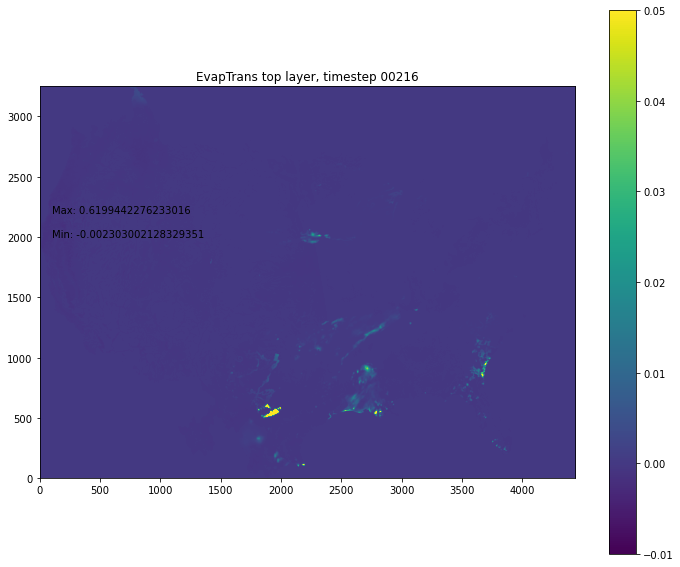

In [11]:
et_top = ET_file[9, :, :]
print(f'Max: {et_top.max()}')
print(f'Min: {et_top.min()}')

plt.figure(figsize = (12,10))
plt.imshow(et_top, origin="lower", vmin = -0.01, vmax = 0.05)
plt.colorbar()
plt.title(f'EvapTrans top layer, timestep {timestep}')
plt.annotate(f'Max: {np.nanmax(et_top)}', xy = (100,2200))
plt.annotate(f'Min: {np.nanmin(et_top)}', xy = (100,2000))

#### 5. Plot pressure

Max: 14.992229549561793
Min: -21.05174206889356


Text(0.5, 1.0, 'Pressure top layer, timestep 00216')

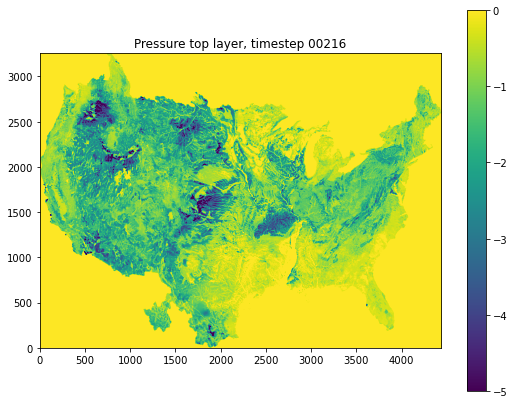

In [9]:
#press_file[press_file < -90000000000000] = 'Nan'
press_top = press_file[9, :, :]
print(f'Max: {np.nanmax(press_top)}')
print(f'Min: {np.nanmin(press_top)}')

plt.figure(figsize = (9,7))
plt.imshow(press_top, origin="lower", vmin = -5, vmax = 0)
plt.colorbar()
plt.title(f'Pressure top layer, timestep {timestep}')
#plt.annotate(f'Max: {np.nanmax(press_top)}', xy = (100,2200))
#plt.annotate(f'Min: {np.nanmin(press_top)}', xy = (100,2000))

#### A. Hoang Initial Spinup Pressure

In [31]:
hoang_init_press = pf.read_pfb('/glade/scratch/tijerina/from_hoang/CONUS2_spinup_all_seepage.out.press.08754.pfb')

Max: 72.02130637945105
Min: -21.05173434300854


Text(0.5, 1.0, 'Hoang Initial Pressure, top layer')

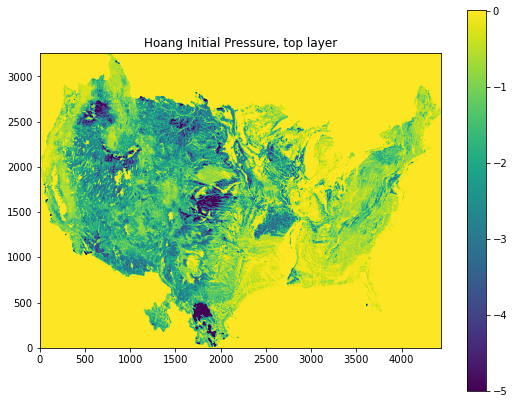

In [41]:
hoang_init_press[hoang_init_press < -90000000000000] = 'Nan'
hoang_press_top = hoang_init_press[9, :, :]
print(f'Max: {np.nanmax(hoang_press_top)}')
print(f'Min: {np.nanmin(hoang_press_top)}')

plt.figure(figsize = (9,7))
plt.imshow(press_top, origin="lower", vmin = -5, vmax = 0.01)
plt.colorbar()
plt.title(f'Hoang Initial Pressure, top layer')
#plt.annotate(f'Max: {np.nanmax(hoang_press_top)}', xy = (100,2200))
#plt.annotate(f'Min: {np.nanmin(hoang_press_top)}', xy = (100,2000))